In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

In [2]:
config_paths = {
    "luna16":"../../luna16/LUNA16/",
    "segment":"../../luna16/seg-lungs-LUNA16/",
    "annotations":"../../luna16/annotations.csv",
    "candidates":"../../luna16/candidates.csv",
    "slide_v1":"../center-coord-chunk",
    "slide_v2":"../center-coord-chunk-v2",
}

annotations = pd.read_csv(config_paths['annotations'])

In [3]:
from dsets import getCandidateInfoList

candidates_info = getCandidateInfoList()

example_cadidate = candidates_info[0]
example_cadidate

CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))

In [4]:
from dsets import Ct

center_xyz = example_cadidate.center_xyz


load_image = Ct(example_cadidate.series_uid)

In [5]:
slide, center_irc = load_image.getRawCandidate(center_xyz, (16, 50, 50))
center_irc
# 

IrcTuple(index=91, row=360, col=341)

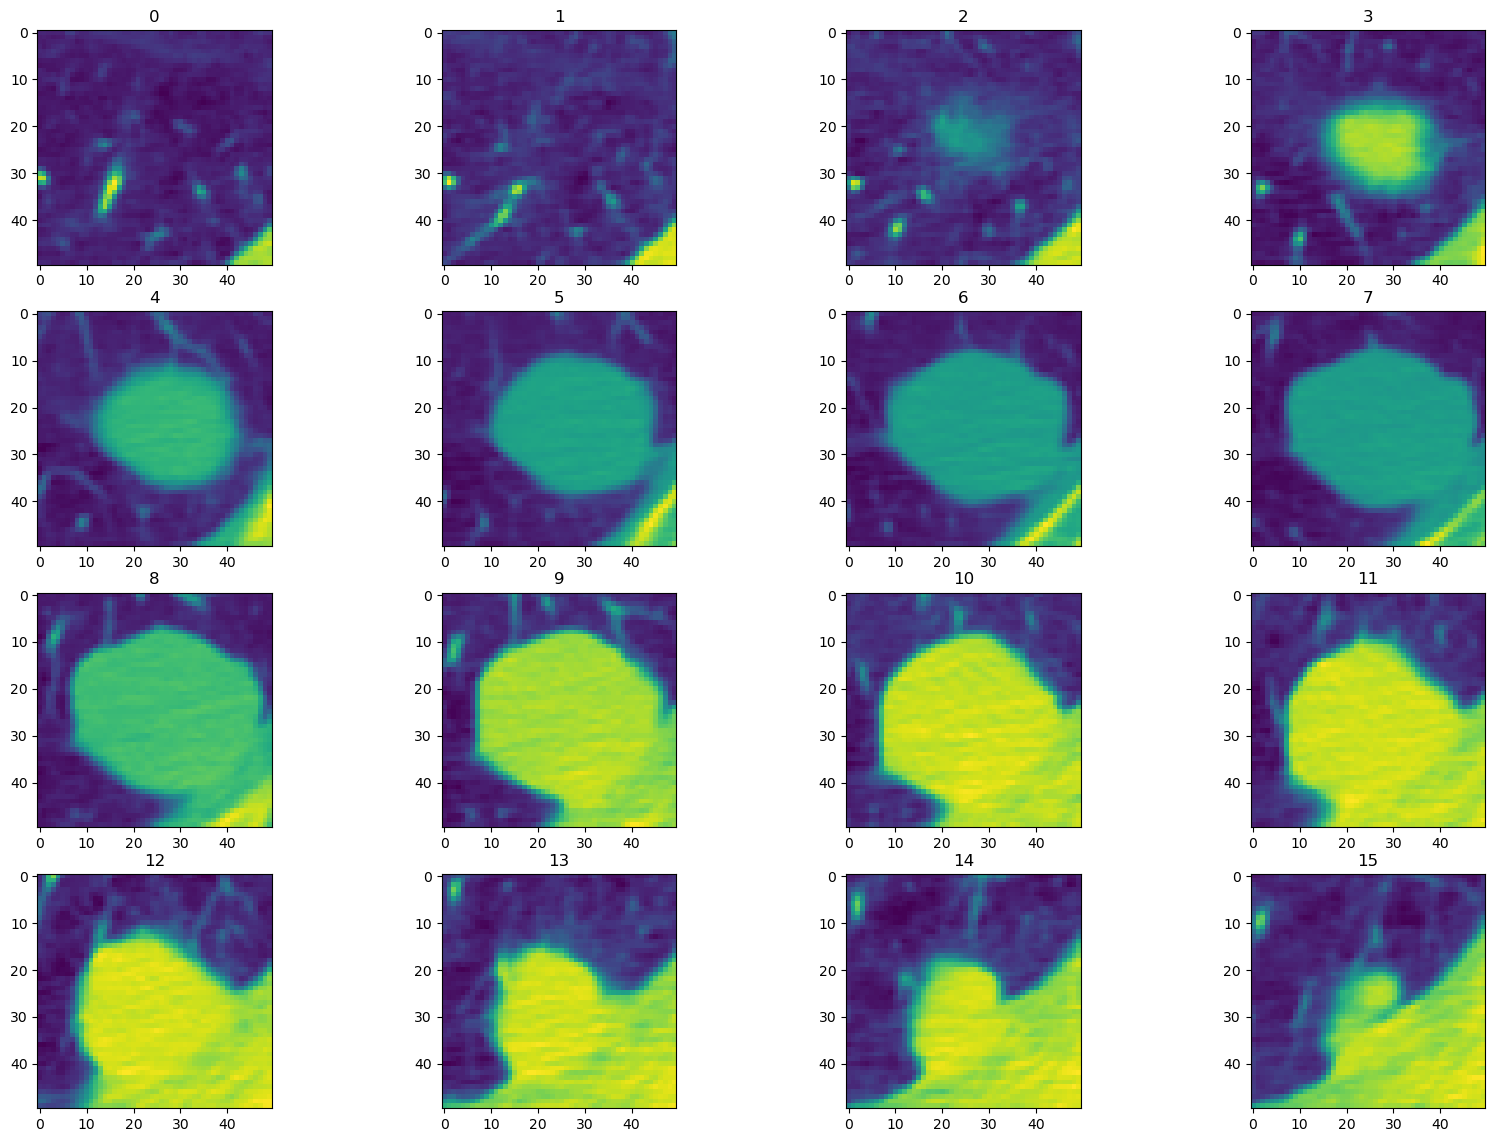

In [6]:
# vẽ lát cắt raw (16,, 50, 50) của nodule

from util import  plot_ct

plot_ct(slide, list(range(len(slide))))

In [7]:
slide_image = load_image.hu_a[91]

center_xyz
diamiter = example_cadidate.diameter_mm
diamiter
x_low = center_xyz[0] - diamiter/2
y_low = center_xyz[1] - diamiter/2
z_low = center_xyz[2] - diamiter/2

origin = load_image.origin_xyz
vxel = load_image.vxSize_xyz
direction = load_image.direction_a

from util import xyz2irc

lower_irc = xyz2irc((x_low, y_low, z_low), origin, vxel, direction)
lower_irc

IrcTuple(index=85, row=340, col=321)

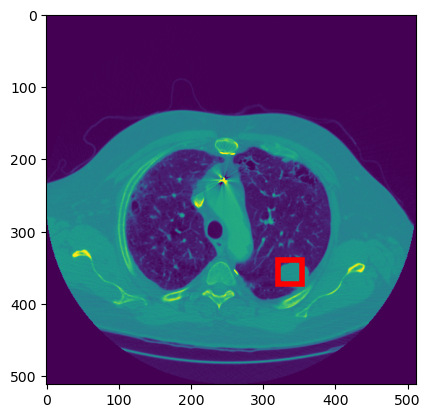

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

#display the image
plt.imshow(slide_image)
# plt.scatter(341, 360, color="red")

#add rectangle
plt.gca().add_patch(Rectangle((321, 340), diamiter, diamiter,
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
# plt.savefig("ct_image.png")

In [9]:
def plot_ct_scan_bbox(image, index, lower_irc, diamiter):
    """
    image: np.array of iamge
    index: list index have mask value
    """
    num_fig = int(np.ceil(np.sqrt(len(index))))


    fig, axs = plt.subplots(num_fig, num_fig, figsize=(20,14))

    slide = 0
    for x in range(num_fig):
        for y in range(num_fig):
            try:
                axs[x, y].imshow(image[index[slide]])
                axs[x, y].set_title(index[slide])
                rect = Rectangle((lower_irc[2], lower_irc[1]), diamiter, diamiter, linewidth=1, edgecolor='r', facecolor='none')
                axs[x, y].add_patch(rect)

                slide += 1
                # print(slide)
            except:
                pass
            
    plt.show()

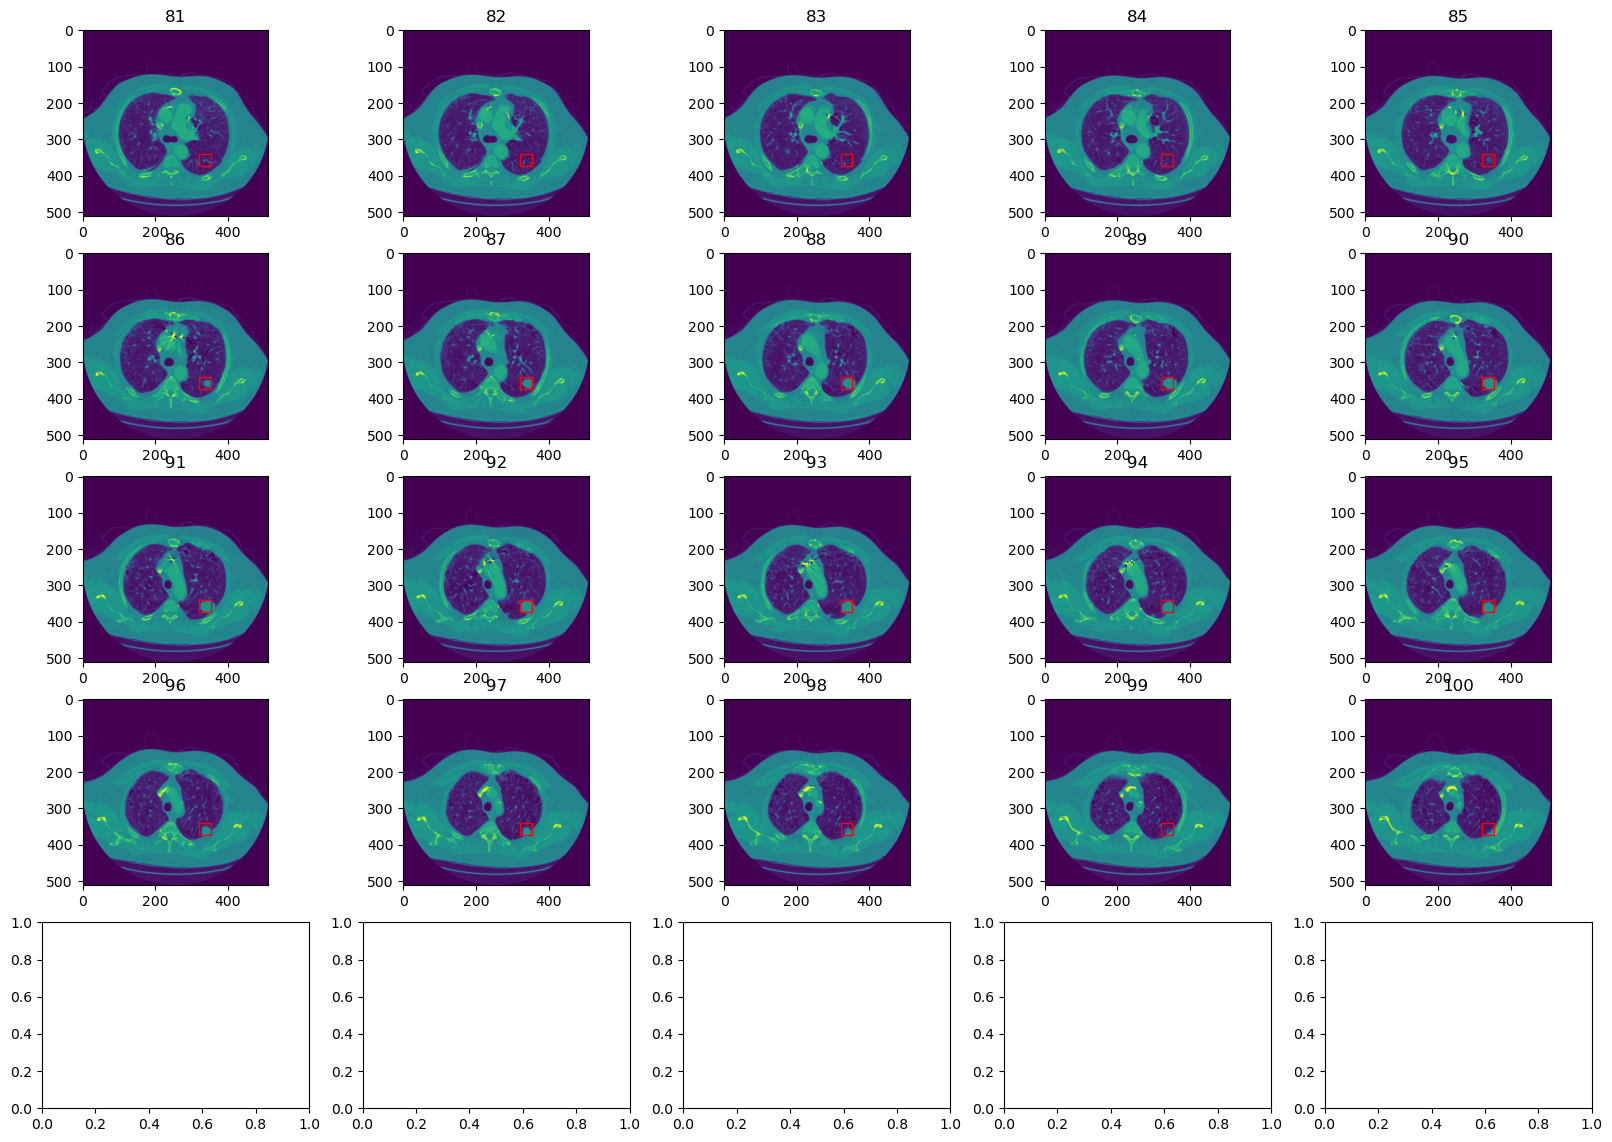

In [10]:
# from util import plot_ct_scan_bbox

image = load_image.hu_a
index = list(range(center_irc[0] - 10, center_irc[0] + 10))
lower_irc
diamiter


plot_ct_scan_bbox(image, index, lower_irc, diamiter)

### Candidate vs segment

In [11]:
import SimpleITK as sitk

example_cadidate

CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))

In [12]:
# path = glob.glob(config_paths["segment"] + "1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd*")[0]
# index = list(range(center_irc[0] - 10, center_irc[0] + 10))

# ct_mhd = sitk.ReadImage(path)
# ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
# ct_a = ct_a == 4

# # plot_ct(ct_a, index)


In [13]:
paths = glob.glob(config_paths["segment"] + "*.mhd")

def pulmonary_percentage():
    total = 0
    pulmonary = 0

    for path in paths:
        ct_mhd = sitk.ReadImage(path)
        load = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        total += load.size
        pulmonary += np.count_nonzero(load == 3)
        pulmonary += np.count_nonzero(load == 4)

    return total, pulmonary 

# pulmonary_percentage()       
# 8214377577/(8214377577 + 59565670400) = 0.1211